In [1]:
#импортируем нужные либы
import pandahouse as ph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,10)}
        )

In [3]:
#объявляем параметры подключения (оригинальные параметры скрыты для безопасности)
connection_default = {'host': 'http://clickhouse.go.pro:5757',
                      'database':'default',
                      'user':'GK', 
                      'password':'fhfhf3736hfc7r'
                     }

In [4]:
#Запрос расчитывает расстояние от жилья до центра и выводит объявления, в которых расстояние меньше среднего

query1 = """

WITH
    (
    SELECT AVG(geoDistance(13.4050, 52.5200, toFloat32OrNull(longitude), toFloat32OrNull(latitude)))
    FROM listings 
    WHERE room_type='Private room' 
    ) as avg_dist
    
SELECT 
    host_id,
    geoDistance(13.4050, 52.5200, toFloat32OrNull(longitude), toFloat32OrNull(latitude)) AS distance,
    toFloat32OrNull(replaceAll(price, '$', '')) + toFloat32OrNull(replaceAll(cleaning_fee, '$', '')) / 7 AS day_price,
    toDateOrZero(last_review) as last_review,
    amenities
FROM listings
WHERE 
    distance < avg_dist AND 
    day_price < 100 AND 
    last_review > '2018-09-01' AND
    multiSearchAnyCaseInsensitive(amenities, ['WiFi']) !=0
ORDER BY toFloat32OrNull(review_scores_rating) DESC 
LIMIT 100

"""
df = ph.read_clickhouse(query1, connection=connection_default)
df

,host_id,distance,day_price,last_review,amenities
0,39740677,2528.391602,53.571429,2018-11-04,"{Wifi,Kitchen,Elevator,Heating,Washer,Dryer,""S..."
1,20173692,4208.450195,81.428571,2018-09-16,"{Wifi,Kitchen,Heating,Washer,Essentials,""Lapto..."
2,19577506,3922.759277,52.857143,2018-09-02,"{Wifi,Kitchen,""Pets live on this property"",""Ot..."
3,9208115,2411.463379,52.857143,2018-10-21,"{TV,Wifi,Kitchen,""Free street parking"",Heating..."
4,46659004,3760.414551,23.000000,2018-11-06,"{Wifi,Kitchen,""Smoking allowed"",""Free street p..."
...,...,...,...,...,...
95,103138450,1174.691528,35.000000,2018-11-05,"{Wifi,""Smoking allowed"",Elevator,Heating,Essen..."
96,207294251,3234.688477,38.142857,2018-10-03,"{Wifi,Kitchen,""Free parking on premises"",Heati..."
97,13559618,1016.826843,64.571429,2018-10-01,"{TV,Wifi,Kitchen,Elevator,Heating,Washer,Essen..."
98,162631209,1846.987915,35.000000,2018-11-02,"{TV,Wifi,Heating,Washer,""Smoke detector"",""Firs..."


In [5]:
#Запрос находит и выводит объявления с доступным жильем, в которых отзывов уникальных пользователей выше среднего

query2 = """
WITH
    (
    SELECT AVG(review_num) 
    FROM (
        SELECT 
            COUNT(DISTINCT(reviewer_id)) review_num, 
         listing_id  
         FROM reviews 
         GROUP BY listing_id
         )
    ) AS avg_review

SELECT
listing_id,
review_num
FROM (
    SELECT
        COUNT(DISTINCT(reviewer_id)) review_num,
        listing_id
    FROM reviews
    GROUP BY listing_id
    ) AS r
JOIN (
    SELECT
        listing_id
    FROM calendar_summary
    WHERE available='t' 
GROUP BY listing_id
    ) AS c
ON
    c.listing_id = r.listing_id
WHERE review_num > avg_review  
ORDER BY listing_id
LIMIT 10

"""
df = ph.read_clickhouse(query2, connection=connection_default)
df.head(7)

,listing_id,review_num
0,2015,118
1,3176,142
2,3309,25
3,7071,195
4,14325,23
5,16644,48
6,17409,275


In [6]:
# Простой запрос, группирует данные по району и виду впечатлений, а потом подсчитывает количество объявлений в каждой группе. 
# Хочу просто показать связку с визуализацией

query3 = """ 
SELECT 
    neighbourhood_cleansed, 
    experiences_offered,
    COUNT(experiences_offered) AS experiences_count 
FROM
    ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC 
limit 100
"""

exp_count = ph.read_clickhouse(query3, connection=connection_default)
exp_count.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


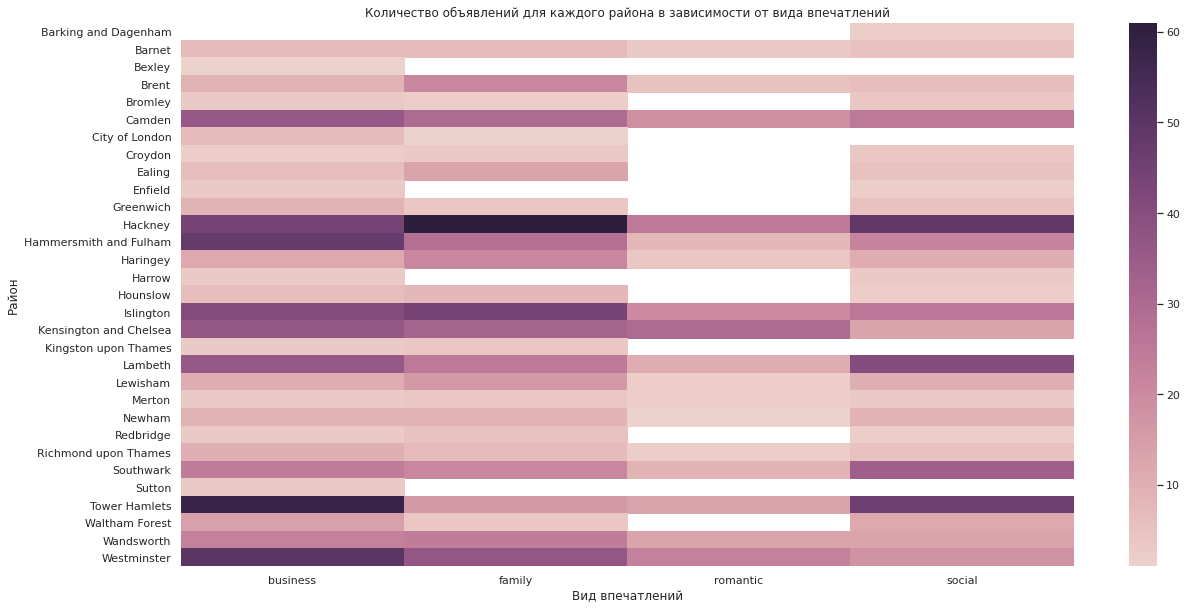

In [7]:
# График показывает количество объявлений для каждого района в зависимости от вида впечатлений.
# Чем темнее ячейка, тем больше объявлений в ячейке район - вид впечатления 

exp_piv = exp_count.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
sns.heatmap(exp_piv, cmap=sns.cubehelix_palette(as_cmap=True))
plt.xlabel('Вид впечатлений')
plt.ylabel('Район')
plt.title('Количество объявлений для каждого района в зависимости от вида впечатлений')
plt.show()

In [8]:
# Запрос для демонстрации связки с визуализацией

query4 = """
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
FROM
    ldn_listings
WHERE 
    first_review > '2010-01-01'
    LIMIT 1000
"""

price_mean = ph.read_clickhouse(query4, connection=connection_default)
price_mean.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [9]:
price_mean.first_review = pd.to_datetime(price_mean.first_review).dt.year
price_mean_fin = pd.DataFrame(price_mean.groupby(['room_type', 'first_review'])['price'].mean().round()) \
                .reset_index() \
                .rename(columns ={'first_review': 'year'})

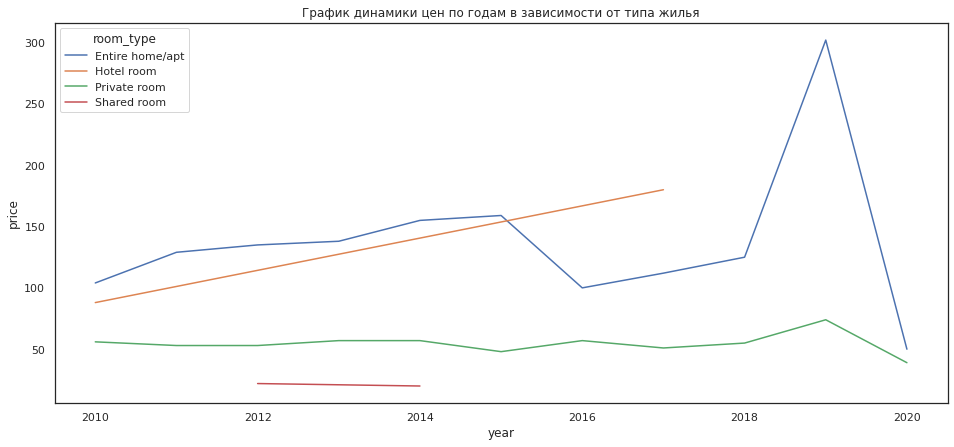

In [10]:
plt.figure(figsize=(16,7))
sns.set_style('white')
sns.lineplot(data=price_mean_fin, x='year', y='price', hue='room_type')
plt.title('График динамики цен по годам в зависимости от типа жилья')
plt.show()